In [6]:
import os
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt

# Get list of all CSV files in the directory
list_of_files = list(Path("../../logs/breaking_points_fainder").rglob("*.csv"))

# Find the latest file
latest_file = max(list_of_files, key=os.path.getctime)

# Load the latest CSV file into a DataFrame
df_latest = pd.read_csv(latest_file)
#"timestamp,fainder_mode,filter_size_wrong,filter_size_right,filter_size,filter_size_wrong_doc,filter_size_right_doc,filter_size_doc,execution_time,execution_time_first,num_results_first,num_results,query

# add a column number of fainder mode changes
df_latest["fainder_mode_change"] = 0
df_latest.loc[1:, "fainder_mode_change"] = (df_latest["fainder_mode"] != df_latest["fainder_mode"].shift()).cumsum()
print(df_latest)

               timestamp fainder_mode  filter_size_wrong  filter_size_right  \
0    2025-05-12 18:52:32  full_recall                  0                  0   
1    2025-05-12 18:52:33  full_recall               1407             164046   
2    2025-05-12 18:52:36  full_recall               3015             472378   
3    2025-05-12 18:52:40  full_recall               5494             728131   
4    2025-05-12 18:52:44  full_recall               5606             769541   
..                   ...          ...                ...                ...   
714  2025-05-12 21:57:24        exact              18264            3162922   
715  2025-05-12 21:57:44        exact              19089            3167255   
716  2025-05-12 21:58:05        exact              19102            3171034   
717  2025-05-12 21:58:25        exact              19122            3174763   
718  2025-05-12 21:58:47        exact              19282            3431768   

     filter_size  filter_size_wrong_doc  filter_siz

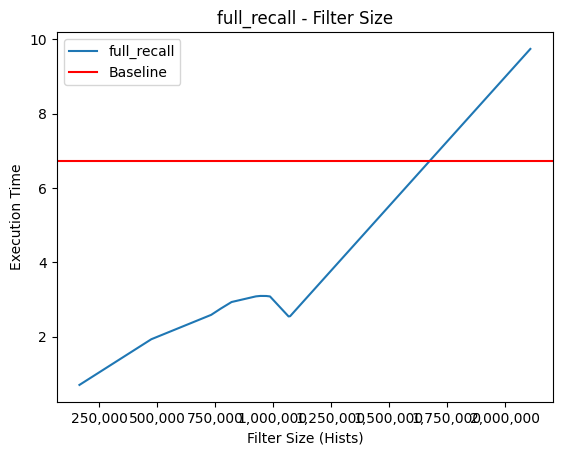

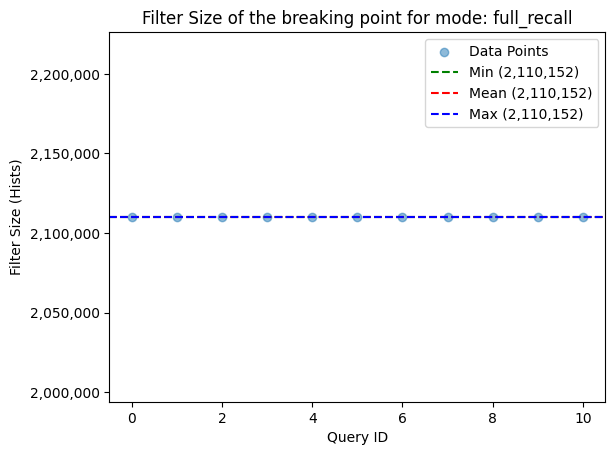

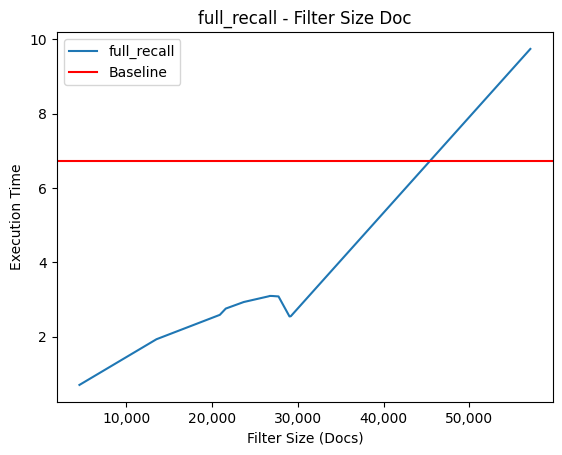

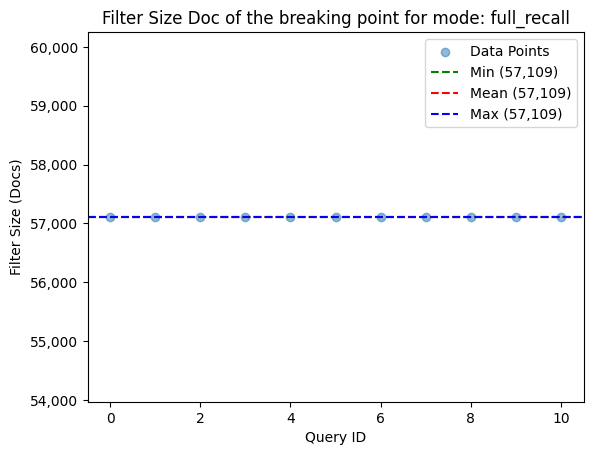

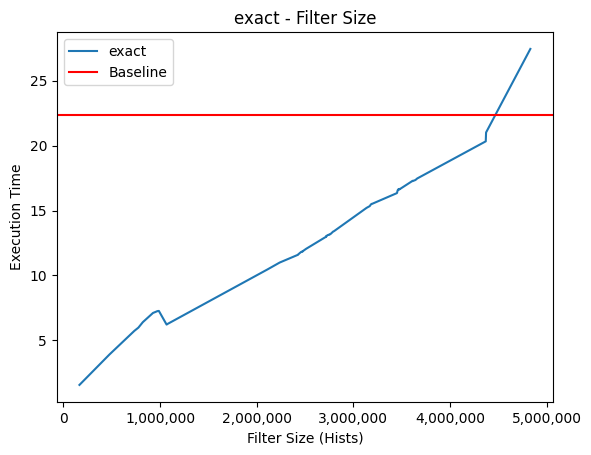

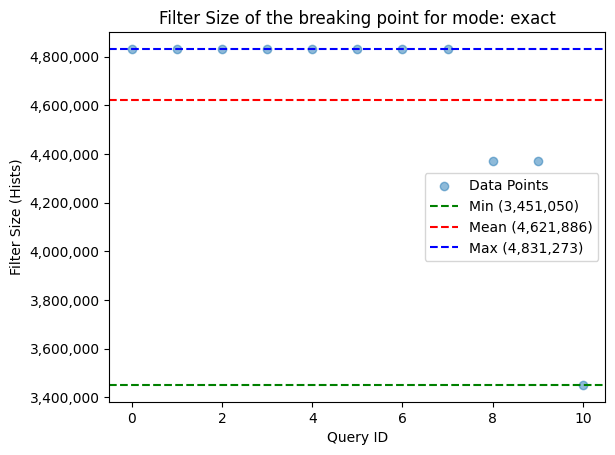

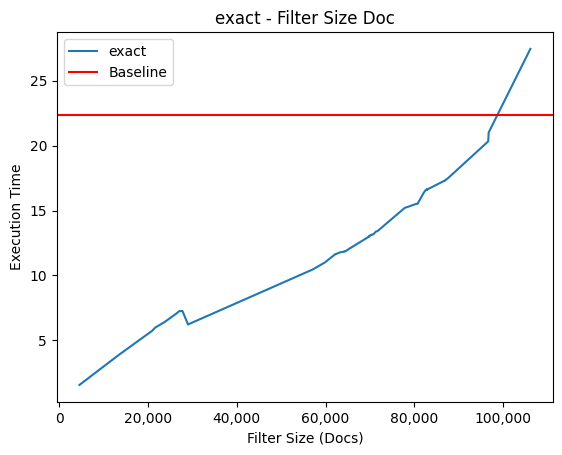

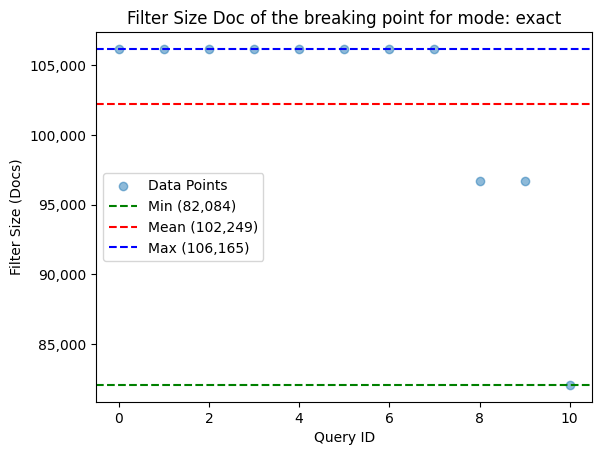

In [7]:
# One plot for each fainder mode 
# Use filter_size 0 as the baseline
# x-axis: filter_size y-axis: execution_time
# First set of plots for filter_size
df_baseline = df_latest[df_latest["filter_size"] == 0]
df_latest_nonzero = df_latest[df_latest["filter_size"] != 0]

for fainder_mode in df_latest_nonzero["fainder_mode"].unique():
    df_fainder_mode = df_latest_nonzero[df_latest_nonzero["fainder_mode"] == fainder_mode]
    df_fainder_mode = df_fainder_mode.groupby("filter_size")["execution_time"].mean().reset_index()
    df_fainder_mode = df_fainder_mode.sort_values("filter_size")
    df_fainder_mode = df_fainder_mode.reset_index(drop=True)
    df_baseline_mode = df_baseline[df_baseline["fainder_mode"] == fainder_mode]

    plt.figure()
    plt.title(f"{fainder_mode} - Filter Size")
    plt.xlabel("Filter Size (Hists)")
    plt.ylabel("Execution Time")
    plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.plot(df_fainder_mode["filter_size"], df_fainder_mode["execution_time"], label=fainder_mode)
    plt.axhline(y=df_baseline_mode["execution_time"].mean(), color='r', linestyle='-', label="Baseline")
    plt.legend()
    plt.show()

    # one plot for min, mean, max of biggest filter_size per query
    df_fainder_mode = df_latest_nonzero[df_latest_nonzero["fainder_mode"] == fainder_mode]
    df_fainder_mode = df_fainder_mode.loc[df_fainder_mode.groupby('fainder_mode_change')['filter_size'].idxmax()]
    df_fainder_mode.reset_index(drop=True, inplace=True)
    
    plt.figure()
    plt.title(f"Filter Size of the breaking point for mode: {fainder_mode}")
    plt.scatter(df_fainder_mode.index, df_fainder_mode["filter_size"], alpha=0.5, label='Data Points')
    plt.axhline(y=df_fainder_mode["filter_size"].min(), color='g', linestyle='--', label=f'Min ({int(df_fainder_mode["filter_size"].min()):,})')
    plt.axhline(y=df_fainder_mode["filter_size"].mean(), color='r', linestyle='--', label=f'Mean ({int(df_fainder_mode["filter_size"].mean()):,})')
    plt.axhline(y=df_fainder_mode["filter_size"].max(), color='b', linestyle='--', label=f'Max ({int(df_fainder_mode["filter_size"].max()):,})')
    plt.xlabel("Query ID")
    plt.ylabel("Filter Size (Hists)")
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    plt.show()

    # Same plots for filter_size_doc
    df_fainder_mode = df_latest_nonzero[df_latest_nonzero["fainder_mode"] == fainder_mode]
    df_fainder_mode = df_fainder_mode.groupby("filter_size_doc")["execution_time"].mean().reset_index()
    df_fainder_mode = df_fainder_mode.sort_values("filter_size_doc")
    df_fainder_mode = df_fainder_mode.reset_index(drop=True)
    
    plt.figure()
    plt.title(f"{fainder_mode} - Filter Size Doc")
    plt.xlabel("Filter Size (Docs)")
    plt.ylabel("Execution Time")
    plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.plot(df_fainder_mode["filter_size_doc"], df_fainder_mode["execution_time"], label=fainder_mode)
    plt.axhline(y=df_baseline_mode["execution_time"].mean(), color='r', linestyle='-', label="Baseline")
    plt.legend()
    plt.show()

    # one plot for min, mean, max of biggest filter_size_doc per query
    df_fainder_mode = df_latest_nonzero[df_latest_nonzero["fainder_mode"] == fainder_mode]
    df_fainder_mode = df_fainder_mode.loc[df_fainder_mode.groupby('fainder_mode_change')['filter_size_doc'].idxmax()]
    df_fainder_mode.reset_index(drop=True, inplace=True)
    
    plt.figure()
    plt.title(f"Filter Size Doc of the breaking point for mode: {fainder_mode}")
    plt.scatter(df_fainder_mode.index, df_fainder_mode["filter_size_doc"], alpha=0.5, label='Data Points')
    plt.axhline(y=df_fainder_mode["filter_size_doc"].min(), color='g', linestyle='--', label=f'Min ({int(df_fainder_mode["filter_size_doc"].min()):,})')
    plt.axhline(y=df_fainder_mode["filter_size_doc"].mean(), color='r', linestyle='--', label=f'Mean ({int(df_fainder_mode["filter_size_doc"].mean()):,})')
    plt.axhline(y=df_fainder_mode["filter_size_doc"].max(), color='b', linestyle='--', label=f'Max ({int(df_fainder_mode["filter_size_doc"].max()):,})')
    plt.xlabel("Query ID")
    plt.ylabel("Filter Size (Docs)")
    plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.legend()
    plt.show()


